<a href="https://colab.research.google.com/github/YohaanKhan/CNNs/blob/main/CNNforMNISTDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependencies

In [ ]:
!pip install torch
!pip install torchinfo
!pip install torchvision
!pip install matplotlib

# Importing the Required Libraries

In [ ]:
import torch
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Defining Hyperparameters

In [ ]:
lr = 1e-4  #Learning rate - controls the size of the updates made to the model's parameters based on the gradient of the loss function.
num_epochs = 40 #Epochs - A reference to the complete go-through of the dataset once
batch_size = 64 #Batch Size - A reference to the number of inputs being passed through the neural network in one iteration of a training cycle

# Loading and Normalizing the Dataset

In [ ]:
transform = transforms.Compose([ #transform.Compose is used to include all the transformations in a single pipeline
    transforms.ToTensor(), #Converts the PIL image into tensor, in this case, it has an input of 28 x 28 greyscale images, so we divide the values assigned to each pixel by 255 to get a value between 0 to 1.
    transforms.Normalize((0.1307,), (0.3081,))  #The dataset is normalized with the mean and standard deviation of the dataset
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform) #Root specifies where we can access the dataset from, Train is assigned true as we are going to train on this dataset, download is assigned true allows the function to download the data in case it is missing from the stated location, and finally we apply the transformations we defined earlier to each and every image.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True) #We select the trainset data defined above, then we ensure that the training takes place with the desired batch sizes and finally we assign True value to the shuffling as we do not want the dataset to learn irrelevant order patterns from the dataset.


# Building the Convolutional Neural Network

In [ ]:
class MNISTConvNet(nn.Module):
  def __init__(self):
    super(MNISTConvNet, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 32, 5, padding = 'same'), #We define the input as 1 with the same dimension as earlier 28 x 28 ( as we kept padding as same) into a 5x5 kernel with the output being 32 channels
        nn.ReLU(), #The relu activation function
        nn.MaxPool2d(2) #It halves the spatial dimensions with 2 x 2 window (14 x 14)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, 5, padding = 'same'), #We define the input as 32 with the same dimension as earlier 14 x 14 ( as we kept padding as same) into a 5x5 kernel with the output being 64 channels
        nn.ReLU(), #The relu activation function
        nn.MaxPool2d(2) #It halves the spatial dimensions with 2 x 2 window (7 x 7)
    )
    self.fc1 = nn.Sequential(
        nn.Flatten(), #Flattens the 7 x 7 x 64 tensor into a 1D vector
        nn.Linear(7 * 7 * 64, 1024), #it takes the 1D vector of size 3136 and maps it to a 1D vector of size 1024
        nn.Dropout(0.5), #Dropout(0.5) is used to prevent overfitting by randomly setting half of the neurons to zero during training.
        nn.Linear(1024, 10)  # The final output is a tensor of shape (batch_size, 10), corresponding to the logits for the 10 MNIST classes.
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.fc1(x)
    return x



# Model Summary


In [ ]:
model = MNISTConvNet()
summary(model, input_size=(1, 1, 28, 28)) #It summarizes the layers, output shapes and parameters of a model

Layer (type:depth-idx)                   Output Shape              Param #
MNISTConvNet                             [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           832
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
├─Sequential: 1-2                        [1, 64, 7, 7]             --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           51,264
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 64, 7, 7]             --
├─Sequential: 1-3                        [1, 10]                   --
│    └─Flatten: 2-7                      [1, 3136]                 --
│    └─Linear: 2-8                       [1, 1024]                 3,212,288
│    └─Dropout: 2-9                      [1, 1024]                 --
│  

# Training the Model and Getting the results

In [ ]:

model = MNISTConvNet() #Initializes the convulational neural network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #This statement checks if a GPU is available if yes, it switches to that, or else it utilises the CPU
model.to(device)  #Moves the model to whichever device is available CPU OR GPU

optimizer = torch.optim.Adam(model.parameters(), lr=lr) #This utilises the Adam Optimizer that adjusts the learning rate of each parameter based on its gradient, furthermore passing the parameters into the optimizer and passing in the learning rate as well.
loss_fn = nn.CrossEntropyLoss() #Cross-Entropy Loss is a common loss function used for classification tasks. It compares the model's predictions to the true labels and computes the error.

train_losses = [] #This stores the losses for each epoch for further analysis.
train_accuracies = [] #This stores the accuracies for each epoch for further analysis.

for epoch in range(num_epochs):
    running_loss = 0.0
    num_correct = 0
    total_samples = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() #This clears any previous gradients stored by the optimizer, this prevents them from accumulating across batches
        outputs = model(inputs) #The inputs are passed through the model and the output is calculated
        loss = loss_fn(outputs, labels) #Calculates the loss function by comparing the outputs and the labels
        loss.backward() #This computes the gradient of the loss with respect to each parameter using backpropogation
        optimizer.step() #This updates the model parameters using the gradients calculated by the loss.backward()

        running_loss += loss.item()
        _, predicted = outputs.max(dim=1)
        num_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = num_correct / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

print("Training complete!")



Epoch 1/40, Loss: 0.2236, Accuracy: 0.9358
Epoch 2/40, Loss: 0.0669, Accuracy: 0.9798
Epoch 3/40, Loss: 0.0499, Accuracy: 0.9849
Epoch 4/40, Loss: 0.0397, Accuracy: 0.9878
Epoch 5/40, Loss: 0.0325, Accuracy: 0.9901
Epoch 6/40, Loss: 0.0282, Accuracy: 0.9913
Epoch 7/40, Loss: 0.0238, Accuracy: 0.9927
Epoch 8/40, Loss: 0.0199, Accuracy: 0.9937
Epoch 9/40, Loss: 0.0166, Accuracy: 0.9948
Epoch 10/40, Loss: 0.0146, Accuracy: 0.9952
Epoch 11/40, Loss: 0.0130, Accuracy: 0.9956
Epoch 12/40, Loss: 0.0103, Accuracy: 0.9969
Epoch 13/40, Loss: 0.0095, Accuracy: 0.9970
Epoch 14/40, Loss: 0.0081, Accuracy: 0.9975
Epoch 15/40, Loss: 0.0083, Accuracy: 0.9972
Epoch 16/40, Loss: 0.0062, Accuracy: 0.9982
Epoch 17/40, Loss: 0.0055, Accuracy: 0.9984
Epoch 18/40, Loss: 0.0057, Accuracy: 0.9982
Epoch 19/40, Loss: 0.0040, Accuracy: 0.9988
Epoch 20/40, Loss: 0.0053, Accuracy: 0.9983
Epoch 21/40, Loss: 0.0034, Accuracy: 0.9988
Epoch 22/40, Loss: 0.0036, Accuracy: 0.9988
Epoch 23/40, Loss: 0.0027, Accuracy: 0.99

# Visualising the Models Training Performance

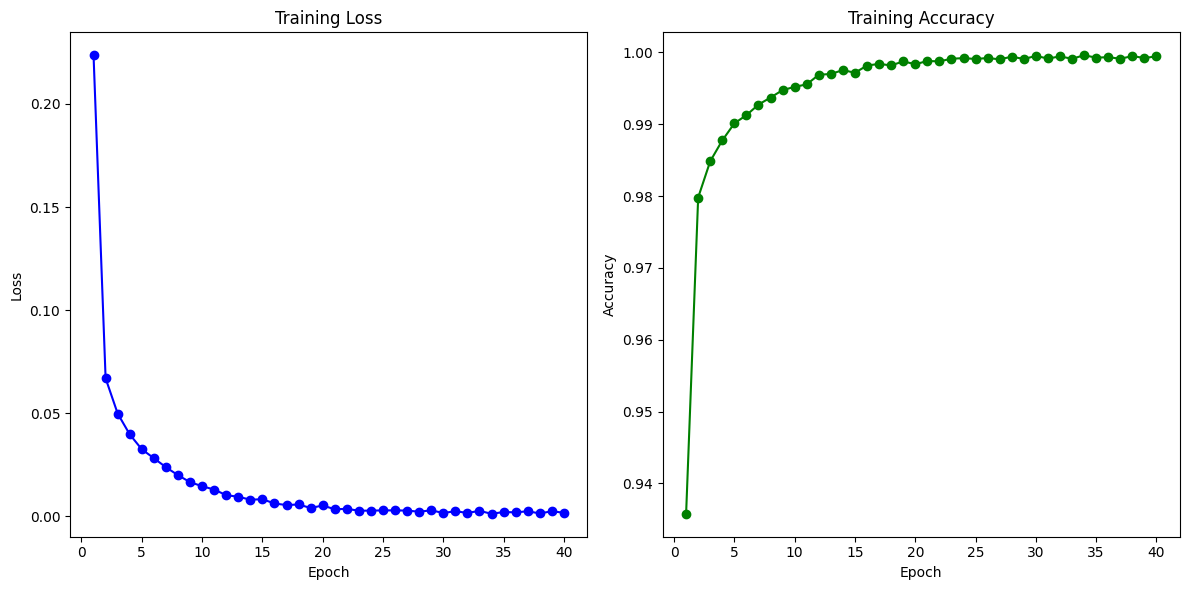

In [ ]:
import matplotlib.pyplot as plt

# Plotting training loss
plt.figure(figsize=(12, 6))

# Training Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Training Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', linestyle='-', color='g')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show the plots
plt.tight_layout()
plt.show()


# Loading the Test Dataset

In [ ]:
# Load the MNIST test set
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform) #Again accessing the dataset from the root location, train is set to false as we are using this for testing purposes, download is set to true as it will allow us to download the dataset if not found at root, lastly the transform applies the defined transformation to each image of the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False) #We utilise the test set, with the batch size as initialised earlier as 64 and shuffle is switched off.


# Evaluating the Test Dataset

In [ ]:
model.eval()  #The dropout will be disabled and batch normalization will utilise the running statistics rather than the batch statistics

num_correct = 0
total_samples = 0

with torch.no_grad():  #No gradients are to be calculated for this test set
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(dim=1)
        num_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)


test_accuracy = num_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9926


# Visualizing the first 10 outputs and predictions

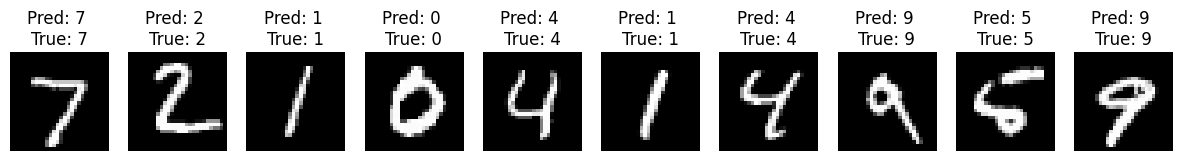

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


model.eval() # Sets model to evaluation mode


data_iter = iter(testloader) # Gets a batch of test images
images, labels = next(data_iter)  # Get the next batch of images and labels


images, labels = images.to(device), labels.to(device) # Move images and labels to the appropriate device


outputs = model(images) # Pass the images through the model


_, predicted = outputs.max(dim=1) # Get the predicted labels


fig, axes = plt.subplots(1, 10, figsize=(15, 1.5)) # Plot the images with predicted and true labels

for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    ax.set_title(f"Pred: {predicted[i].item()} \nTrue: {labels[i].item()}")
    ax.axis('off')

plt.show()


# Save the Model

In [ ]:
torch.save(model.state_dict(), 'khansmodel.pth')


# **Training Model Accuracy after 10 epochs: 0.9952**

# **Training Model Accuracy after 20 epochs: 0.9983**

# **Training Model Accuracy after 30 epochs: 0.9995**

# **Training Model Accuracy after 40 epochs: 0.9994**

# **Test Accuracy: 0.9926**